# Software fundamentals for Neural Networks
February 2024
* Johanna Norell
* Andreas Helgesson
* Axel Blom

In [ ]:
# Import necessary packages
import pandas as pd
import numpy as np
import torch
from torch import nn

/shared-libs/python3.9/py/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Extracting the Data

In [ ]:
!wget --no-check-certificate https://www.cse.chalmers.se/~richajo/dit866/assignments/a4/data/a4_synthetic.csv

--2024-02-26 10:07:20--  https://www.cse.chalmers.se/~richajo/dit866/assignments/a4/data/a4_synthetic.csv
Resolving www.cse.chalmers.se (www.cse.chalmers.se)... 129.16.222.93
Connecting to www.cse.chalmers.se (www.cse.chalmers.se)|129.16.222.93|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5874 (5.7K) [text/csv]
Saving to: ‘a4_synthetic.csv.35’

a4_synthetic.csv.35 100%[===================>]   5.74K  --.-KB/s    in 0s      

2024-02-26 10:07:21 (79.3 MB/s) - ‘a4_synthetic.csv.35’ saved [5874/5874]



Loading the synthetic dataset.

In [ ]:
# You may need to edit the path, depending on where you put the files.
data = pd.read_csv('a4_synthetic.csv')

X = data.drop(columns='y').to_numpy()
Y = data.y.to_numpy()

Training a linear regression model for this synthetic dataset.

In [ ]:
np.random.seed(1)

w_init = np.random.normal(size=(2, 1))
b_init = np.random.normal(size=(1, 1))

# Declaring tensors with parameters
w = torch.tensor(w_init, dtype=torch.float, requires_grad=True)
b = torch.tensor(b_init, dtype=torch.float, requires_grad=True)

#Declaring learning rate and algorithm used for optimization
eta = 1e-2
opt = torch.optim.SGD([w,b], lr=eta)

#Training the model
for i in range(10):

    sum_err = 0

    for row in range(X.shape[0]):
        x = torch.tensor(X[[row], :], dtype=torch.float32)
        y = torch.tensor(Y[[row]])

        # Forward pass.
        y_pred = x@w + b # linear: y=ax+b
        err = (y - y_pred)**2

        # Backward and update.
        opt.zero_grad() # Resets the gradients of all optimized
        err.backward() # Computes the gradient of current tensor wrt graph leaves
        opt.step() # Performs a single optimization step (parameter update)

        # For statistics.
        sum_err += err.item()

    mse = sum_err / X.shape[0]
    print(f'Epoch {i+1}: MSE =', mse)

Epoch 1: MSE = 0.7999662623416189
Epoch 2: MSE = 0.01739239492736053
Epoch 3: MSE = 0.009377417782394874
Epoch 4: MSE = 0.009355326801683737
Epoch 5: MSE = 0.009365440374032813
Epoch 6: MSE = 0.0093669889321558
Epoch 7: MSE = 0.009367207355115736
Epoch 8: MSE = 0.009367237678977408
Epoch 9: MSE = 0.00936724428618897
Epoch 10: MSE = 0.009367244374616222


# Building Tensors

In [ ]:
class Tensor:

    # Constructor. Just store the input values.
    def __init__(self, data, requires_grad=False, grad_fn=None):
        self.data = data
        self.shape = data.shape
        self.grad_fn = grad_fn
        self.requires_grad = requires_grad
        self.grad = None

    # So that we can print the object or show it in a notebook cell.
    def __repr__(self):
        dstr = repr(self.data)
        if self.requires_grad:
            gstr = ', requires_grad=True'
        elif self.grad_fn is not None:
            gstr = f', grad_fn={self.grad_fn}'
        else:
            gstr = ''
        return f'Tensor({dstr}{gstr})'

    # Extract one numerical value from this tensor.
    def item(self):
        return self.data.item()


    # Operator +
    def __add__(self, right):
        return addition(self, right)

    # Operator -
    def __sub__(self, right):
        return subtraction(self, right)

    # Operator @
    def __matmul__(self, right):
        return multiplication(self, right)

    # Operator **
    def __pow__(self, right):
        # NOTE! We are assuming that right is an integer here, not a Tensor!
        if not isinstance(right, int):
            raise Exception('only integers allowed')
        if right < 2:
            raise Exception('power must be >= 2')
        return power(self,right)


    # Backward computations. Will be implemented in Task 4.
    def backward(self, grad_output=None):
        # We first check if this tensor has a grad_fn: that is, one of the
        # nodes that you defined in Task 3.
        if self.grad_fn is not None: # If has been created by a computation
            # If grad_fn is defined, we have computed this tensor using some operation.
            if grad_output is None:
                # This is the starting point of the backward computation.
                # This will typically be the tensor storing the output of
                # the loss function, on which we have called .backward()
                # in the training loop.

                # TODO compute grad output
                grad_output = np.array([1])
                self.grad_fn.backward(grad_output)

            else:
                # This is an intermediate node in the computational graph.
                # This corresponds to any intermediate computation, such as
                # a hidden layer.

                # TODO compute(update) grad output
                self.grad_fn.backward(grad_output)
        else:
            # If grad_fn is not defined, this is an endpoint in the computational
            # graph: learnable model parameters or input data.
            if self.requires_grad:
                # This tensor *requires* a gradient to be computed. This will
                # typically be a tensor that holds learnable parameters.

                # TODO compute(update) grad output
                self.grad = np.transpose(grad_output)
                return # Terminate recursion
            else:
                # This tensor *does not require* a gradient to be computed. This
                # will typically be a tensor holding input data.
                #self.grad = grad_output
                return # Terminate recursion


# A small utility where we simply create a Tensor object. We use this to
# mimic torch.tensor.
def tensor(data, requires_grad=False):
    return Tensor(data, requires_grad)


# Helper functions to implement the various arithmetic operations.
# Takes two tensors as input, and returns a new tensor holding
# the result of an element-wise addition on the two input tensors.

#Helper method for addition
def addition(left, right):
    new_data = left.data + right.data
    if left.requires_grad or right.requires_grad:
      grad_fn = AdditionNode(left, right)
    else:
      grad_fn = None
    return Tensor(new_data,left.requires_grad or right.requires_grad, grad_fn=grad_fn)

#Helper method for subtraction
def subtraction(left, right):
  new_data = left.data - right.data
  if left.requires_grad or right.requires_grad:
      grad_fn = SubtractionNode(left, right)
  else:
      grad_fn = None
  return Tensor(new_data,left.requires_grad or right.requires_grad, grad_fn=grad_fn)

#Helper method for multiplication
def multiplication(left, right):
  new_data = left.data @ right.data
  if left.requires_grad or right.requires_grad:
      grad_fn = MultiplicationNode(left, right)
  else:
      grad_fn = None
  return Tensor(new_data,left.requires_grad or right.requires_grad, grad_fn=grad_fn)

#Helper method for power
def power(left, right):
  new_data = left.data ** right
  if left.requires_grad:
      grad_fn = PowerNode(left, right)
  else:
      grad_fn = None
  return Tensor(new_data,left.requires_grad, grad_fn=grad_fn)

Some sanity checks.

In [ ]:
# Two tensors holding row vectors.
x1 = tensor(np.array([[2.0, 3.0]]))
x2 = tensor(np.array([[1.0, 4.0]]))
# A tensors holding a column vector.
w = tensor(np.array([[-1.0], [1.2]]))

# Test the arithmetic operations.
test_plus = x1 + x2
test_minus = x1 - x2
test_power = x2 ** 2
test_matmul = x1 @ w

print(f'Test of addition: {x1.data} + {x2.data} = {test_plus.data}')
print(f'Test of subtraction: {x1.data} - {x2.data} = {test_minus.data}')
print(f'Test of power: {x2.data} ** 2 = {test_power.data}')
print(f'Test of matrix multiplication: {x1.data} @ {w.data} = {test_matmul.data}')

# Check that the results are as expected. Will crash if there is a miscalculation.
assert(np.allclose(test_plus.data, np.array([[3.0, 7.0]])))
assert(np.allclose(test_minus.data, np.array([[1.0, -1.0]])))
assert(np.allclose(test_power.data, np.array([[1.0, 16.0]])))
assert(np.allclose(test_matmul.data, np.array([[1.6]])))

Test of addition: [[2. 3.]] + [[1. 4.]] = [[3. 7.]]
Test of subtraction: [[2. 3.]] - [[1. 4.]] = [[ 1. -1.]]
Test of power: [[1. 4.]] ** 2 = [[ 1. 16.]]
Test of matrix multiplication: [[2. 3.]] @ [[-1. ]
 [ 1.2]] = [[1.6]]


# Defining node-types

In [ ]:
class Node:
    def __init__(self):
        pass

    def backward(self, grad_output):
        raise NotImplementedError('Unimplemented')

    def __repr__(self):
        return str(type(self))

# Backward gradient calculations as per:
# Addition: g*(left+right) --> g, g
# Subtraction: g*(left-right) --> g, -g
# Multiplication: g*(left*right) --> g*right, g*left
# Power: g*(left^right) --> g*right*left^(right-1), ___

#AdditionNode class defined to support backpropagation
class AdditionNode(Node):
    def __init__(self, left, right):
        self.left = left
        self.right = right

    def backward(self, grad_output):
      if self.left.requires_grad:
        self.left.backward(grad_output)
      if self.right.requires_grad:
        self.right.backward(grad_output)

#SubtractionNode class defined to support backpropagation
class SubtractionNode(Node):
    def __init__(self, left, right):
        self.left = left
        self.right = right

    def backward(self, grad_output):
      if self.left.requires_grad:
        self.left.backward(grad_output)
      if self.right.requires_grad:
        self.right.backward(-grad_output)

#MultiplicationNode class defined to support backpropagation
class MultiplicationNode(Node):
    def __init__(self, left, right):
        self.left = left
        self.right = right

    def backward(self, grad_output):
        if self.left.requires_grad:
            self.left.backward(self.right.data * grad_output)
        if self.right.requires_grad:
            self.right.backward(self.left.data * grad_output)

# Adjustment to make node handle matrix multiplication, cannot get it working for task 4/5 but task 6...
#    def backward(self, grad_output):
#      if self.left.requires_grad:
#        if len(self.right.data.shape) > 1:  # Matrix
#            grad_left = np.dot(grad_output, self.right.data.T)
#        else:
#            grad_left = (self.right.data * grad_output)
#        self.left.backward(grad_left)
#      if self.right.requires_grad:
#        if len(self.left.data.shape) > 1:
#            grad_right = np.dot(self.left.data.T, grad_output)
#        else:
#            grad_right = (self.left.data * grad_output)
#        self.right.backward(grad_right)

#PowerNode class defined to support backpropagation
class PowerNode(Node):
    def __init__(self, left, right):
        self.left = left
        self.right = right

    def backward(self, grad_output):
        if self.left.requires_grad:
            self.left.backward(self.right * grad_output * (self.left.data ** (self.right-1))) # Correct /Andreas
        # No need to calculate gradient w.r.t. exponent


Sanity check for Task 3.

In [ ]:
x = tensor(np.array([[2.0, 3.0]]))
w1 = tensor(np.array([[1.0, 4.0]]), requires_grad=True)
w2 = tensor(np.array([[3.0, -1.0]]), requires_grad=True)

test_graph = x + w1 + w2

print('Computational graph top node after x + w1 + w2:', test_graph.grad_fn)

assert(isinstance(test_graph.grad_fn, AdditionNode))
assert(test_graph.grad_fn.right is w2)
assert(test_graph.grad_fn.left.grad_fn.left is x)
assert(test_graph.grad_fn.left.grad_fn.right is w1)

Computational graph top node after x + w1 + w2: <class '__main__.AdditionNode'>


Sanity check for Task 4.

In [ ]:
x = tensor(np.array([[2.0, 3.0]]))
w = tensor(np.array([[-1.0], [1.2]]), requires_grad=True)
y = tensor(np.array([[0.2]]))

# We could as well write simply loss = (x @ w - y)**2
# We break it down into steps here if you need to debug.

model_out = x @ w
diff = model_out - y
loss = diff ** 2

loss.backward()

print('Gradient of loss w.r.t. w =\n', w.grad)

assert(np.allclose(w.grad, np.array([[5.6], [8.4]])))
assert(x.grad is None)
assert(y.grad is None)

Gradient of loss w.r.t. w =
 [[5.6]
 [8.4]]


An equivalent cell using PyTorch code. Your implementation should give the same result for `w.grad`.

In [ ]:
pt_x = torch.tensor(np.array([[2.0, 3.0]]))
pt_w = torch.tensor(np.array([[-1.0], [1.2]]), requires_grad=True)
pt_y = torch.tensor(np.array([[0.2]]))

pt_model_out = pt_x @ pt_w
pt_model_out.retain_grad() # Keep the gradient of intermediate nodes for debugging.

pt_diff = pt_model_out - pt_y
pt_diff.retain_grad()

pt_loss = pt_diff ** 2
pt_loss.retain_grad()

pt_loss.backward()
pt_w.grad

tensor([[5.6000],
        [8.4000]], dtype=torch.float64)

# Building Optimizers

In [ ]:
class Optimizer:
    def __init__(self, params):
        self.params = params

    def zero_grad(self):
        for p in self.params:
            p.grad = np.zeros_like(p.data)

    def step(self):
        raise NotImplementedError('Unimplemented')


class SGD(Optimizer):
    def __init__(self, params, lr):
        super().__init__(params)
        self.lr = lr

    def step(self):
        # TODO
        for p in self.params:
            # Update parameter using SGD: param = param - lr * grad
            p.data -= self.lr * p.grad

In [ ]:
np.random.seed(1)

w_init = np.random.normal(size=(2, 1))
b_init = np.random.normal(size=(1, 1))

# We just declare the parameter with our created tensors
w = tensor(w_init, requires_grad=True)
b = tensor(b_init, requires_grad=True)

eta = 1e-2
opt = SGD([w,b], lr=eta)

for i in range(10):

    sum_err = 0

    for row in range(X.shape[0]):
        x = tensor(X[[row], :])
        y = tensor(Y[[row]])

        # Forward pass.
        y_pred = x @w + b # linear: y=ax+b
        err = (y - y_pred)**2

        # Backward and update.
        opt.zero_grad() # Resets the gradients of all optimized
        err.backward() # Computes the gradient of current tensor wrt graph leaves
        opt.step() # Performs a single optimization step (parameter update)

        # For statistics.
        sum_err += err.item()

    mse = sum_err / X.shape[0]
    print(f'Epoch {i+1}: MSE =', mse)

Epoch 1: MSE = 0.7999661130823178
Epoch 2: MSE = 0.017392390107906875
Epoch 3: MSE = 0.009377418010839892
Epoch 4: MSE = 0.009355326971438456
Epoch 5: MSE = 0.009365440968904256
Epoch 6: MSE = 0.009366989180952533
Epoch 7: MSE = 0.009367207398577986
Epoch 8: MSE = 0.009367238983974489
Epoch 9: MSE = 0.009367243704122532
Epoch 10: MSE = 0.009367244427185763


# Extracting more data

In [ ]:
!wget --no-check-certificate https://www.cse.chalmers.se/~richajo/dit866/assignments/a4/data/raisins.csv

--2024-02-26 10:07:22--  https://www.cse.chalmers.se/~richajo/dit866/assignments/a4/data/raisins.csv
Resolving www.cse.chalmers.se (www.cse.chalmers.se)... 129.16.222.93
Connecting to www.cse.chalmers.se (www.cse.chalmers.se)|129.16.222.93|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68230 (67K) [text/csv]
Saving to: ‘raisins.csv.22’

raisins.csv.22      100%[===================>]  66.63K   315KB/s    in 0.2s    

2024-02-26 10:07:23 (315 KB/s) - ‘raisins.csv.22’ saved [68230/68230]



In [ ]:
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split

# You may need to edit the path, depending on where you put the files.
a4data = pd.read_csv('raisins.csv')

X = scale(a4data.drop(columns='Class'))
Y = 1.0*(a4data.Class == 'Besni').to_numpy()

np.random.seed(0)
shuffle = np.random.permutation(len(Y))
X = X[shuffle]
Y = Y[shuffle]

Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, random_state=0, test_size=0.2)

In [ ]:
Xtrain.shape, Ytrain.shape

((720, 7), (720,))

In [ ]:
#Initilizing the new type of nodes needed

# Backward gradient calculations as per:
# Tanh: 1 - (tanh(x))^2
# Sigmoid: x(1-x)
# BinaryCrossEntropy:

class TanhNode(Node):
    def __init__(self, input_tensor):
        self.input_tensor = input_tensor

    def backward(self, grad_output):
        if self.input_tensor.requires_grad:
            self.input_tensor.backward((1 - np.square(np.tanh(self.input_tensor.data))) * grad_output)

class SigmoidNode(Node):
    def __init__(self, input_tensor):
        super().__init__()
        self.input_tensor = input_tensor

    def backward(self, grad_output):
        if self.input_tensor.requires_grad:
            self.input_tensor.backward((self.input_tensor.data * (1 - self.input_tensor.data)) * grad_output)


class BinaryCrossEntropyNode(Node):
    def __init__(self, input_tensor):
        super().__init__()
        self.input_tensor = input_tensor

    def backward(self, grad_output):
        if self.input_tensor.requires_grad:
            # Compute the gradient of binary cross-entropy loss with respect to input_tensor
            grad_loss = -((self.input_tensor.data[0].data / self.input_tensor.data[1].data[0][0]) - ((1 - self.input_tensor.data[0].data) / (1 - self.input_tensor.data[1].data[0][0])))
            # Backpropagate the gradient
            self.input_tensor.backward(grad_output * grad_loss)

    def forward(self):
       # https://pytorch.org/docs/stable/_modules/torch/nn/modules/loss.html#BCELoss
       # def forward(self, input: Tensor, target: Tensor) -> Tensor:
       # return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)

       # https://www.analyticsvidhya.com/blog/2021/03/binary-cross-entropy-log-loss-for-binary-classification/
       ytrue = self.input_tensor.data[0].data
       ypred = self.input_tensor.data[1].data[0][0]
       return -(ytrue*np.log(ypred) + (1-ytrue)*np.log(1-ypred))

class BinaryCrossEntropyNode2(Node):
    def __init__(self, left, right):
        super().__init__()
        self.left = left #y_pred
        self.right = right #y

    def backward(self, grad_output):
        if self.left.requires_grad or self.right.requires_grad:
            self.left.backward(grad_output * (0-self.right.data) * ((0-1)/(1+np.exp(0-self.left.data) * (1/(1+np.exp(0-self.left.data))))))

In [ ]:
#Defining new functions needed

def tanh(input_tensor):
    output_tensor = Tensor(np.tanh(input_tensor.data), requires_grad=input_tensor.requires_grad)
    if input_tensor.requires_grad:
        output_tensor.grad_fn = TanhNode(input_tensor)
    return output_tensor

def sigmoid(input_tensor):
    output_tensor = Tensor(1 / (1 + np.exp(-input_tensor.data)), requires_grad=input_tensor.requires_grad)
    if input_tensor.requires_grad:
        output_tensor.grad_fn = SigmoidNode(input_tensor)
    return output_tensor

def binary_cross_entropy(input_tensor):
    loss_tensor = Tensor(BinaryCrossEntropyNode(input_tensor).forward(), requires_grad=y_pred.requires_grad)

    if y_pred.requires_grad:
        loss_tensor.grad_fn = BinaryCrossEntropyNode(input_tensor)
    return loss_tensor

#Remove before we hand in if this is useless
def binary_cross_entropy2(y_pred, y_true):
    # Assuming y_pred and y_true are Tensors with requires_grad set appropriately for y_pred
    # Compute the binary cross entropy loss
    bce_loss_value = -(y_true.data * np.log(y_pred.data) + (1 - y_true.data) * np.log(1 - y_pred.data))
    loss_tensor = Tensor(np.array([bce_loss_value]), requires_grad=y_pred.requires_grad)

    if y_pred.requires_grad:
        loss_tensor.grad_fn = BinaryCrossEntropyNode2(y_pred, y_true)

    return loss_tensor

In [ ]:
import matplotlib.pyplot as plt

Epoch 1: Log loss = 0.8479121498632477
Epoch 2: Log loss = 0.8479121498632477
Epoch 3: Log loss = 0.8479121498632477
Epoch 4: Log loss = 0.8479121498632477
Epoch 5: Log loss = 0.8479121498632477
Epoch 6: Log loss = 0.8479121498632477
Epoch 7: Log loss = 0.8479121498632477
Epoch 8: Log loss = 0.8479121498632477
Epoch 9: Log loss = 0.8479121498632477
Epoch 10: Log loss = 0.8479121498632477


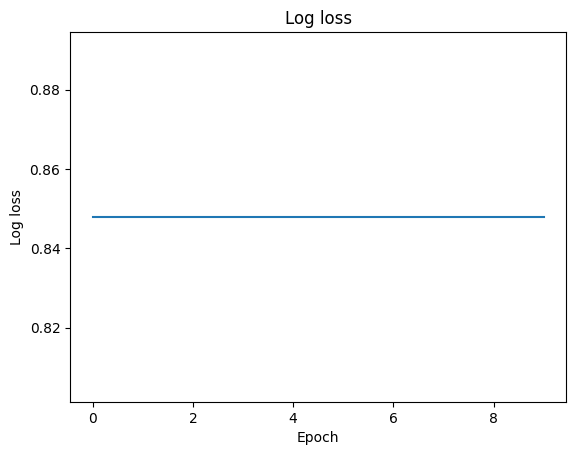

In [ ]:
#Initilizing the model structure to have one hidden layer and binary classification

h_size = 36 #Randomly choosing a hidden layer size, this should be adjusted/tested
o_size = 1 #Output size = 1 since task is binary classification

#Initilizing the first hidden layer
w1 = tensor(np.random.normal(0,1, (Xtrain.shape[1], h_size)), requires_grad=True)
b1 = tensor(np.zeros((1,h_size)), requires_grad=True)

#Initilizing the output layer
w2 = tensor(np.random.normal(0,1,(h_size, o_size)), requires_grad=True)
b2 = tensor(np.zeros((1,o_size)), requires_grad=True)


#Training the model
epochs = 10 #Number of epochs to be adjusted/tested
eta = 1e-2
opt = SGD([w1,b1,w2,b2], lr=eta)

plot_data = []

for i in range(epochs):

    sum_err = 0

    for row in range(Xtrain.shape[0]):
        x = tensor(Xtrain[[row], :], requires_grad=False)
        y = tensor(Ytrain[[row]], requires_grad=False)

        # Hidden layer
        z1 = x @ w1 + b1
        h1 = tanh(z1)

        #Output layer
        z2 = h1 @ w2 + b2
        y_pred = sigmoid(z2)

        # Create a tensor with y_true and y_pred
        loss_input = tensor(np.array((y, y_pred)), requires_grad=True)

        # Binary cross entropy loss
        err = binary_cross_entropy(loss_input)
        #err = binary_cross_entropy2(y_pred, y) #Remove before hand in if not used

        # Backward and update.
        opt.zero_grad() # Resets the gradients of all optimized
        err.backward() # Computes the gradient of current tensor wrt graph leaves
        opt.step() # Performs a single optimization step (parameter update)

        # For statistics.
        sum_err += err.item()

    log_loss = sum_err / Xtrain.shape[0]
    print(f'Epoch {i+1}: Log loss =', log_loss)
    plot_data.append(log_loss)

plt.plot(plot_data)
plt.title('Log loss')
plt.xlabel('Epoch')
plt.ylabel('Log loss')
plt.show()

Something is clearly wrong in our implementation here, but we are not sure what. Our implemetnation of BCE seems to always return a gradient of 0, hence why the log loss does not update. Running with our other implementation, however, gives a matrix multiplication error in the backward() function in MultiplicationNode, so we rewrote it like the below:

>MultiplicationNode class for Task 6
    class MultiplicationNode(Node):
        def __init__(self, left, right):
            self.left = left
            self.right = right
    
        def backward(self, grad_output):
        if self.left.requires_grad:
            if len(self.right.data.shape) > 1:  # Matrix
                grad_left = np.dot(grad_output, self.right.data.T)
            else:
                grad_left = (self.right.data * grad_output)
            self.left.backward(grad_left)
        if self.right.requires_grad:
            if len(self.left.data.shape) > 1:
                grad_right = np.dot(self.left.data.T, grad_output)
            else:
                grad_right = (self.left.data * grad_output)
            self.right.backward(grad_right)

This yields working code in Task 6, but results in errors in Task 4 and 5. With this working Task 6, the next step would be to evaluate the model on the testing data to see the accuracy.

However, due to the approaching deadline, we are not able to fix these issues and so we will submit it as is (with the mandatory tasks 1-5 working).

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=1b094071-690d-44cb-8cd4-a16b2af2a809' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>